# 实战阿里天池竞赛——服饰属性标签识别

近期阿里巴巴的天池算法竞赛平台上线了一场有着高额奖金的算法竞赛：[FashionAI全球挑战赛—服饰属性标签识别](https://tianchi.aliyun.com/competition/information.htm?spm=5176.100067.5678.2.5f1b3a26SDt1nT&raceId=231649)。第一名队伍将有50万人民币的奖金！是不是非常动心？

在这场竞赛中，主办方提供了八种不同服饰的图片数据，每种服饰的训练数据有大约一万张图片，选手们的任务就是设计一个算法对图片中服饰的属性做出准确判断。例如其中的裙子类图片，就分为不可见，短裙，中裙，七分裙，九分裙和长裙等总共六种属性。我们可以将其视为经典的图片分类问题，并通过卷积神经网络来解决。

`MXNet`是一个易安装易上手的开源深度学习工具，它提供了一个python接口`gluon`，能够让大家很快地搭建起神经网络，并进行高效训练。在本篇教程中，我们将以比赛中的裙子任务为例，向大家展示如何用`gluon`从零开始，设计一个简单而又效果好的卷积神经网络算法。

## 一、环境配置

### 系统配置

对于深度学习训练而言，用GPU加速训练是很重要的。这次竞赛的数据量虽然不算大，但是只用CPU计算可能还是会让一次模型训练花上好几天的时间！因此我们建议大家使用至少一块GPU来进行训练。还没有GPU的同学，可以参考如下两种选择：

1. 根据自己的预算和需求入手（年轻人的第）一块GPU。我们写了一篇[GPU购买指南](http://zh.gluon.ai/chapter_preface/buy-gpu.html)，方便大家选购。
2. 为了这次比赛租用亚马逊云的GPU服务器。我们写了一篇[AWS的运行教程](http://zh.gluon.ai/chapter_preface/aws.html)，帮助大家配置自己的云服务器。

配置好了硬件与系统之后，我们需要安装Nvidia提供的CUDA与CUDNN，从而把我们的代码与GPU硬件真正连接起来。这部分的安装比较容易，可以参考[这一部分](http://zh.gluon.ai/chapter_preface/aws.html#cuda)的指导。

如果选择使用亚马逊云服务器，那么我们建议在选择系统镜像时选择Deep Learning AMI，这个镜像把与GPU训练相关的环境（CUDA，CUDNN）都已经配置好了，不需要做其他的配置了。

### 安装MXNet

配置好了环境之后，我们就可以安装MXNet了。有很多种方式可以安装MXNet，如果要在Linux系统上为python安装GPU版本，只需要执行：

```
pip install mxnet-cu90
```

就可以了。如果系统中安装的是CUDA 8.0，可以将代码改成对应的`mxnet-cu80`。

如果有同学想要使用其他的语言接口或者是操作系统，或者是自己从源码编译，都可以在[官方的安装说明](http://mxnet.incubator.apache.org/install/index.html)中找到符合自己情况的安装步骤。

在接下来的教程中，我们使用MXNet的python接口`gluon`带领大家上手此次竞赛。

## 二、数据处理

### 数据获取

首先我们在当前目录下新建`data`文件夹，然后从官网上将热身数据集，训练数据集和测试数据集下载到`data`中并解压。

比赛的数据可以从[比赛官网](https://tianchi.aliyun.com/competition/information.htm?spm=5176.100067.5678.2.5f1b3a26aUuzge&raceId=231649)获取，不过同学们要登录天池账号并注册参加比赛之后才能下载。主要的数据集有三个：

1. `fashionAI_attributes_train_20180222.tar`是主要训练数据，里面含有八个任务的带标记训练图片。这份教程中我们只选用其中的裙子任务做演示。
2. `fashionAI_attributes_test_a_20180222.tar`是预测数据，里面含有八个任务的不带标记训练图片，我们的目的就是训练出模型之后在这份数据上给出分类预测。
3. `warm_up_train_20180201.tar`是热身数据，里面含有与训练集不重复的裙子训练集图片，是对训练数据很重要的补充。

在进一步运行前，请确认当前的目录结构是这样的：

```
Gluon-FashionAI-Attributes
├── data/
│   ├── base/
│   ├── rank/
│   └── web/
└── FashionAI-Attributes-Skirt.ipynb
```

其中`base`是训练数据集，`rank`是预测数据集，`web`是热身数据集。

注意事项：

1. 下载好的数据在解压前与解压后会各占用约8G的硬盘空间，在接下来的数据整理中我们会将数据复制为更方便的目录结构，因此请预留足够的硬盘空间。
2. 因为图片数据集通常很大，因此`gluon`不会一次性将所有图片读入内存，而是在训练过程中不断读取硬盘上的图片文件。请有条件的同学将图片存在SSD硬盘上，这样可以避免数据读取成为瓶颈，从而大幅提高训练速度。

### 数据整理

`gluon`提供了一个读取图像分类任务数据的接口`gluon.data.vision.ImageFolderDataset`，它期望数据是类似ImageNet的格式组织的，即每一类图片都统一放在一个目录下。我们可以通过下面的代码，将裙子的数据整理成`gluon`可以方便读取的格式，并将10%的数据拿出来做验证集。

首先，我们在`data`下新建一个目录`train_valid`，作为所有整理后数据的目录。

In [1]:
import os

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

mkdir_if_not_exist(['data/train_valid'])

我们选用裙子数据的原因之一，就是热身数据与训练数据中都提供了它的训练图片，从而能让我们能够有更丰富的训练资源。下面我们将分别从热身数据欲训练数据的标记文件中：

1. 读取每张图片的路径和标签
2. 将这张图片按照它的标签放入`data/train_valid`目录下对应的类别目录中
3. 将前90%的数据用做训练，后10%的数据用作验证

第一步，读取训练图片的路径和标签。

In [2]:
# 裙子任务的目录名
task = 'skirt_length_labels'
# 热身数据与训练数据的图片标记文件
warmup_label_dir = 'data/web/Annotations/skirt_length_labels.csv'
base_label_dir = 'data/base/Annotations/label.csv'

image_path = []

with open(warmup_label_dir, 'r') as f:
    lines = f.readlines()
    tokens = [l.rstrip().split(',') for l in lines]
    for path, _, label in tokens:
        image_path.append(('data/web/' + path, label))

with open(base_label_dir, 'r') as f:
    lines = f.readlines()
    tokens = [l.rstrip().split(',') for l in lines]
    for path, tk, label in tokens:
        if tk == task:
            image_path.append(('data/base/' + path, label))

我们来检查一下读入的数据。`image_path`应该由路径和图片对应标签组成，其中标签是若干个`n`和一个`y`组成的字符串，字母`y`出现的位置就是图片对应的类型。

Official Label String: nnnnny


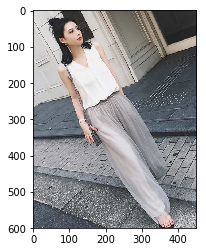

In [3]:
from mxnet import image
import matplotlib.pyplot as plt

def plot_image(img_path):
    with open(img_path, 'rb') as f:
        img = image.imdecode(f.read())
    plt.imshow(img.asnumpy())
    return img

plot_image(image_path[0][0])
print("Official Label String: %s" %(image_path[0][1]))

可以看出这张图中的裙子是长裙，对应上官方的说明，可以发现与标记吻合。

接下来，我们就准备好训练集和测试集的目录，以及6个裙子类别对应的子目录。

In [4]:
mkdir_if_not_exist(['data/train_valid', task])
mkdir_if_not_exist(['data/train_valid', task, 'train'])
mkdir_if_not_exist(['data/train_valid', task, 'val'])
m = len(list(image_path[0][1]))
for mm in range(m):
    mkdir_if_not_exist(['data/train_valid', task, 'train', str(mm)])
    mkdir_if_not_exist(['data/train_valid', task, 'val', str(mm)])

运行后的目录结构如下：
```
train_valid
└── skirt_length_labels
    ├── train
    │   ├── 0
    │   ├── 1
    │   ├── 2
    │   ├── 3
    │   ├── 4
    │   └── 5
    └── val
        ├── 0
        ├── 1
        ├── 2
        ├── 3
        ├── 4
        └── 5
```
要想处理其他类型的服饰，只需要将`task`变量指定为对应的服饰类型名称就行了。

最后，我们将图片复制到各自对应的目录中。需要注意的是，这里我们刻意随机打乱了图片的顺序，从而防止训练集与测试集切分不均匀的情况出现。

In [5]:
import random, shutil

n = len(image_path)
random.seed(1024)
random.shuffle(image_path)
train_count = 0
for path, label in image_path:
    label_index = list(label).index('y')
    if train_count < n * 0.9:
        shutil.copy(path,
                    os.path.join('data/train_valid', task, 'train', str(label_index)))
    else:
        shutil.copy(path,
                    os.path.join('data/train_valid', task, 'val', str(label_index)))
    train_count += 1

## 三、迁移学习

数据准备完毕，接下来我们可以开始着手设计算法了。

这个问题可以被视作计算机视觉中的经典问题：图片分类。一个典型的例子是ImageNet数据集与ILSVRC竞赛，其中选手们要为分别从属于1000个类别的逾1400万张图片设计算法，将它们准确分类。在服饰属性判别竞赛中，我们可以认为不同属性的服饰从属于不同的类别，于是便能参考ImageNet中的优胜算法来参赛。

在初赛阶段，主办方给每类服饰各提供了约一万张图片用来训练，这样的数据量还不足以让我们从零开始训练一个很棒的深度学习模型。于是我们可以借用迁移学习的想法，从一个在ImageNet数据集上被训练好的模型出发，一点点把它改造成“更懂衣服”的模型。如下图所示，左边的是在ImageNet数据集上训练好的网络，右边的是我们即将用来参赛的网络，这两个网络主体结构一致，因此我们可以将主要的网络权重都复制过来。因为两个网络在输出层的分类个数与含义都不一样，我们需要将输出层重新定义并随机初始化。

![fine-tuning.svg](http://zh.gluon.ai/_images/fine-tuning.svg)

在ImageNet数据集上，大家主要用卷积神经网络，而在过去的几年中也出现了很多不同的网络架构。`gluon`官方提供了许多不同的预训练好的卷积神经网络模型，我们在这个比赛中选择效果比较好的`resnet50_v2`模型作为训练的出发点。关于迁移学习更详细的介绍可以参考`gluon`中文教程中的[Fine-tuning: 通过微调来迁移学习](http://zh.gluon.ai/chapter_computer-vision/fine-tuning.html)一节。

首先，我们准备好需要用到的环境。

In [6]:
import mxnet as mx
import numpy as np

import os, time, math, shutil, random

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models

下面我们可以一句话导入预训练好的`resnet50_v2`模型。如果是首次导入模型，代码会需要一点时间下载预训练好的模型。

In [7]:
pretrained_net = models.resnet50_v2(pretrained=True)

在ImageNet上训练的模型输出是1000维的，我们需要定义一个新的`resnet50_v2`网络，其中

1. 输出层之前的权重是预训练好的
2. 输出是6维的，且输出层的权重随机初始化

之后，我们可以根据具体的机器环境选择将网络保存在CPU或者是GPU上。

In [8]:
num_gpu = 1
ctx = [mx.gpu(i) for i in range(num_gpu)] if num_gpu > 0 else [mx.cpu()]

finetune_net = models.resnet50_v2(classes=6)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

在上面代码中的最后一行我们调用了`hybridize`，这是`gluon`的主要特性之一，能将命令式编程构建的模型在执行时把大部分运算转成符号式来执行，这样一方面提高了开发效率，同时也保证了运行速度。关于`hybridize`更详细的介绍可以参考`gluon`中文教程中的[Hybridize：更快和更好移植](http://zh.gluon.ai/chapter_gluon-advances/hybridize.html)一节。

接下来我们定义几个辅助函数，它们分别是

1. 计算Average Precision，官方的结果评价标准。
2. 训练集与验证集的图片增广函数。
3. 每轮训练结束后在测试集上评估的函数

关于图片增广更详细的介绍可以参考`gluon`中文教程中的[图片增广](http://zh.gluon.ai/chapter_computer-vision/image-augmentation.html)一节。

In [9]:
# 计算 Average Precision
def calculate_ap(labels, outputs):
    cnt = 0
    ap = 0.
    for label, output in zip(labels, outputs):
        for lb, op in zip(label.asnumpy().astype(np.int),
                          output.asnumpy()):
            op_argsort = np.argsort(op)[::-1]
            lb_int = int(lb)
            ap += 1.0 / (1+list(op_argsort).index(lb_int))
            cnt += 1
    return ((ap, cnt))

# 训练集图片增广
def transform_train(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 224, 224), resize=256,
                                    rand_crop=True, rand_mirror=True,
                                    mean = np.array([0.485, 0.456, 0.406]),
                                    std = np.array([0.229, 0.224, 0.225]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar())

# 验证集图片增广，没有随机裁剪和翻转
def transform_val(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 224, 224), resize=256,
                                    mean = np.array([0.485, 0.456, 0.406]),
                                    std = np.array([0.229, 0.224, 0.225]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar())

# 在验证集上预测并评估
def validate(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    L = gluon.loss.SoftmaxCrossEntropyLoss()
    AP = 0.
    AP_cnt = 0
    val_loss = 0
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, 
                                          batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, 
                                           batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
        loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        val_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)
        ap, cnt = calculate_ap(label, outputs)
        AP += ap
        AP_cnt += cnt
    _, val_acc = metric.get()
    return ((val_acc, AP / AP_cnt, val_loss / len(val_data)))

下面我们定义一些训练参数。注意，在迁移学习中，我们一般认为整个网络的参数不需要进行很大地改动，只需要在训练数据上微调，因此我们的学习速率都设为一个比较小的值，比如`0.001`。

为了方便演示，我们只循环两轮训练，展示过程。

In [10]:
lr = 1e-3
momentum = 0.9
wd = 1e-4
epochs = 2
batch_size = 64

接下来我们可以读入数据了。经过之前的整理，数据可以用`gluon.data.DataLoader`接口读入

In [11]:
train_path = os.path.join('data/train_valid', task, 'train')
val_path = os.path.join('data/train_valid', task, 'val')

# 定义训练集的 DataLoader
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path, transform=transform_train),
    batch_size=batch_size, shuffle=True, num_workers=4)

# 定义验证集的 DataLoader
val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path, transform=transform_val),
    batch_size=batch_size, shuffle=False, num_workers=4)

下面我们定义网络的优化算法和损失函数。这次比赛中我们选用随机梯度下降就能得到比较好的效果。

分类问题一般用交叉熵作为损失函数，另外，我们除了mAP指标之外也关心模型的准确率。

In [12]:
# 定义 Trainer
trainer = gluon.Trainer(finetune_net.collect_params(),
                        'sgd', {
                            'learning_rate': lr, 'momentum': momentum, 'wd': wd
                        })

# 定义准确率评估函数，损失函数
L = gluon.loss.SoftmaxCrossEntropyLoss()
metric = mx.metric.Accuracy()

至此万事俱备，我们可以开始训练了！再次提醒，这里为了快速演示，我们只做两次循环，为了达到更好的训练效果请记得将`epochs`调大。

In [13]:
for epoch in range(epochs):
    tic = time.time()
    
    train_loss = 0
    metric.reset()
    AP = 0.
    AP_cnt = 0
    
    num_batch = len(train_data)
    
    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)
        ap, cnt = calculate_ap(label, outputs)
        AP += ap
        AP_cnt += cnt

    train_map = AP / AP_cnt
    _, train_acc = metric.get()
    train_loss /= num_batch

    val_acc, val_map, val_loss = validate(finetune_net, val_data, ctx)
    print('[Epoch %d] Train-acc: %.3f, mAP: %.3f, loss: %.3f | Val-acc: %.3f, mAP: %.3f, loss: %.3f | time: %.1f' %
         (epoch, train_acc, train_map, train_loss, val_acc, val_map, val_loss, time.time() - tic))

[Epoch 0] Train-acc: 0.645, mAP: 0.785, loss: 0.921 | Val-acc: 0.801, mAP: 0.889, loss: 0.537 | time: 79.9
[Epoch 1] Train-acc: 0.801, mAP: 0.887, loss: 0.538 | Val-acc: 0.857, mAP: 0.922, loss: 0.385 | time: 73.4


训练结束了，那效果怎么样呢？我们可以直接拿几张测试集的图片出来，用人眼对比一下看看预测的类型是否准确。

In [14]:
skirt_attr = ['Invisible', 'Short', 'Knee', 'Midi', 'Ankle', 'Floor']

def classify_skirt(path):
    img_path = os.path.join('data/rank', path)
    img = plot_image(img_path)
    data, _ = transform_val(img, 0)
    data = data.expand_dims(axis=0)
    # 输出网络预测
    out = finetune_net(data.as_in_context(ctx[0]))
    out = nd.SoftmaxActivation(out)
    pred = int(nd.argmax(out, axis=1).asscalar())
    prob = out[0][pred].asscalar()
    attr_name = skirt_attr[pred]
    return('With prob=%f, %s'%(prob, attr_name))

# 读取测试图片路径
with open('data/rank/Tests/question.csv', 'r') as f:
    lines = f.readlines()
tokens = [l.rstrip().split(',') for l in lines]
test_images = [t[0] for t in tokens if t[1] == task]

'With prob=0.620382, Midi'

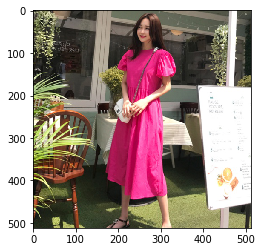

In [15]:
classify_skirt(test_images[0])

'With prob=0.657151, Floor'

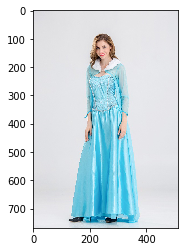

In [16]:
classify_skirt(test_images[2])

'With prob=0.988407, Short'

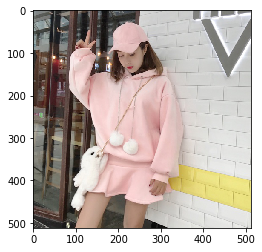

In [17]:
classify_skirt(test_images[3])

'With prob=0.806257, Ankle'

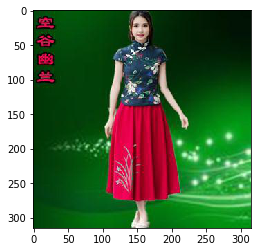

In [18]:
classify_skirt(test_images[5])

'With prob=0.885553, Knee'

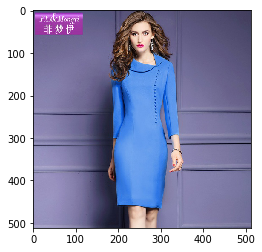

In [19]:
classify_skirt(test_images[1024])

可以看到，虽然只有两轮训练，但我们的模型在展示的几张图片上都做出了正确的预测。

## 四、总结

至此，我们展示了从数据整理直到作出预测的样例代码。你可以从这里开始，不断地改进代码，向着更好的结果出发。

下面我们给出一些可以改进的方向，你可以从他们开始着手：

1. 调整参数，比如学习速率，批量大小，训练循环次数等。
  - 参数之间是有互相影响的，比如更小的学习速率可能意味着更多的循环次数。
  - 建议以验证集上的结果来选择参数
  - 不同数据的最佳参数可能是不一样的，建议对每个任务选取相应的最佳参数
2. 选择模型。
  - 除了ResNet模型之外，`gluon`还提供很多其他流行的卷积神经网络模型，可以到[官方文档](https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html)根据它们在ImageNet上的表现进行选择。
  - 在计算资源有限的情况下，可以考虑选用占内存更小、计算速度更快的模型。
3. 更全面的图片增广
  - 可以考虑在训练时加上更多的图片操作。`image.CreateAugmenter`函数有很多[其他的参数](https://mxnet.incubator.apache.org/api/python/image/image.html?highlight=image.createaugmenter#mxnet.image.CreateAugmenter)，不妨分别试试效果。
  - 在预测时将预测图片做不同的裁剪/微调并分别预测，最后以平均预测值为最后答案，可以得到更稳健的结果。

[吐槽和讨论请点这里](https://discuss.gluon.ai/t/topic/5353)